<a href="https://colab.research.google.com/github/jbastianrj/Dissimilarity-measures-for-time-series-clustering-/blob/main/HCAA_OK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalación de libreria para portafolios y data set
! pip install skfolio
# Instalación de libreria para GAP statistic
! pip install gap-stat
# ! pip install GapStatistic #gapstatistics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.1/691.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.6 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.3.4
    Uninstalling cvxpy-1.3.4:
      Successfully uninstalled cvxpy-1.3.4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependenci

In [ ]:
! pip install gapstatistics

In [ ]:
# Cargamos las librerías necesarias para la implementación
import pandas as pd
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from gap_statistic import OptimalK
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from gapstatistics.gapstatistics import GapStatistics
# from gapstatistics.gapstatistics import GapStatistics

import scipy.spatial.distance as ssd
from skfolio.datasets import load_sp500_dataset
from skfolio.preprocessing import prices_to_returns
from sklearn.model_selection import train_test_split
from scipy.stats import skew, kurtosis

from joblib import Parallel, delayed # Para realizar cálculo de DTW en paralelo

# from sklearn_extra.cluster import KMedoids

In [ ]:
# Cargamos los datos y obtención de rendimientos
prices = load_sp500_dataset()

SP = prices_to_returns(prices)*100  # Para expresarlo en términos de porcentajes
SP_train, SP_test = train_test_split(SP, test_size=0.2, shuffle=False)

In [ ]:
SP_train

,AAPL,AMD,BAC,BBY,CVX,GE,HD,JNJ,JPM,KO,LLY,MRK,MSFT,PEP,PFE,PG,RRC,UNH,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,
1990-01-03,0.757576,-3.030303,0.804523,11.805556,-1.622921,-0.187617,0.358102,0.407213,3.358869,-1.431767,0.000000,1.589561,0.520833,-0.970874,0.293830,-0.181347,0.000000,-1.935484,0.000000,-1.007866
1990-01-04,0.375940,-1.550000,-2.135462,-1.242236,-1.283096,-0.563910,0.624442,0.202781,0.399088,-0.499319,-0.555722,-1.564689,2.849741,-0.980392,1.660156,-1.972489,0.000000,-0.986842,-0.520120,-0.993295
1990-01-05,0.374532,-3.199594,-2.182059,0.000000,-1.485455,-0.945180,-1.329787,-1.040763,0.397501,-0.821168,-1.087449,-2.064057,-2.518892,-1.399053,-0.864553,-1.800371,0.000000,-4.318937,-1.073198,-0.526712
1990-01-08,0.373134,0.000000,0.563317,-7.547170,0.942408,0.572519,-0.988320,1.694420,0.000000,2.115915,0.000000,1.283915,1.550388,1.811831,-0.872093,1.833378,0.000000,-2.083333,1.363004,1.538074
1990-01-09,-0.743494,1.652676,0.000000,0.000000,-0.746888,-2.080259,-2.631579,-3.102557,-3.195701,-0.765766,-1.114674,-0.789285,-0.254453,-1.372213,-2.150538,0.000000,0.000000,-2.482270,-2.661910,-2.011423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-16,3.708844,3.269755,0.360315,2.487301,1.538046,1.079591,1.660028,0.775558,0.751804,0.594824,2.568199,1.431140,1.468122,-0.048502,0.569741,0.492285,-10.283697,1.270703,1.663010,1.025197
2016-05-17,-0.415302,0.000000,0.567755,0.534949,-0.464133,-0.834134,-2.468227,-0.533200,0.000000,-1.906551,-2.427484,-0.606061,-1.865487,-1.690121,-1.046189,-1.237416,4.218956,-0.826263,-1.393916,-0.043647
2016-05-18,1.144525,1.319261,4.856787,-3.572127,-0.684080,-0.337081,-0.174344,-0.211013,3.860312,-0.602800,-0.078311,0.645908,0.592816,-1.425424,0.422064,-0.955617,-1.399562,0.733307,-2.994900,-0.201176


In [ ]:
SP_test

,AAPL,AMD,BAC,BBY,CVX,GE,HD,JNJ,JPM,KO,LLY,MRK,MSFT,PEP,PFE,PG,RRC,UNH,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,
2016-05-23,1.269278,4.392765,-0.344441,2.040895,-0.411428,-0.236469,-0.326592,-0.426670,-0.079207,0.045890,-0.976487,-0.344451,-1.165583,0.320114,-0.208640,0.224647,2.155206,-0.396856,-0.516388,-0.155586
2016-05-24,1.522911,3.960396,1.446829,-7.425612,0.815420,1.220794,1.476734,0.472529,1.701404,0.908778,1.228375,1.237158,3.116166,0.667640,1.279055,0.959090,0.170992,1.663859,1.064586,0.077914
2016-05-25,1.756715,-0.476190,1.640124,4.978558,1.577342,0.803841,-0.120084,0.585745,1.518954,0.022728,-0.599831,1.744761,1.028035,0.000000,0.732645,0.629795,4.064163,0.625720,0.341855,0.658643
2016-05-26,0.795791,4.066986,-1.473340,-0.377373,-0.265862,-0.232916,0.637657,-0.396370,-0.747177,0.698725,1.314937,-0.317049,-0.440949,0.800975,0.233063,-0.318180,-3.232421,-0.329302,0.524892,-0.510472
2016-05-27,-0.060399,5.747126,1.218451,0.253837,0.513249,0.333602,-0.081414,0.140829,0.615071,0.203086,-0.702251,0.157868,0.828312,0.058054,0.521167,0.258970,-0.600773,0.766438,-0.141078,0.234778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-21,2.381061,4.043044,1.522267,1.755180,1.175832,3.300109,1.435835,1.144366,1.124808,1.608965,2.327507,1.276922,1.087381,0.700361,0.663263,0.916965,3.602339,1.409021,0.784360,1.284250
2022-12-22,-2.377515,-5.644208,-0.884763,-0.210850,-1.499796,-1.458172,-1.014619,-0.365526,-1.135502,-0.720924,-0.733863,0.116777,-2.552541,-0.772149,-0.037936,0.230849,-5.050049,-0.085384,-1.170508,-2.016706
2022-12-23,-0.279872,1.033511,0.244307,1.106119,3.091441,0.023538,0.825728,0.253941,0.474909,0.756616,0.709001,0.556776,0.226509,0.646039,0.367522,0.282541,3.939442,0.800655,0.201610,2.643806


In [ ]:
SP_train.to_csv('SP_train.csv')
SP_test.to_csv('SP_test.csv')

In [ ]:
# prices.to_csv('prices_20.csv')

In [ ]:
# Normalizar SP

# # Normalizar los datos
# scaler = MinMaxScaler()
# SP_train_normalized = scaler.fit_transform(SP_train)
# SP_test_normalized = scaler.fit_transform(SP_test)

In [ ]:
# Cargamos la DTW precalculada

# dtw_20 = pd.read_csv('rendimientos_sp_20activos.txt', sep= '\t', index_col=0)
# Contiene las distancias dtw de los rendiemientos sin partición

In [ ]:
# Función que normaliza las matrices (min-max)

def normalizar_matriz(matriz):
    """
    Normaliza una matriz al rango de 0 a 1 utilizando la técnica min-max.

    Parámetros:
    - matriz: np.ndarray
        La matriz que se desea normalizar.

    Retorna:
    - np.ndarray
        La matriz normalizada.
    """
    # Calcula los valores mínimo y máximo de la matriz
    min_valor = np.min(matriz)
    max_valor = np.max(matriz)

    # Normaliza la matriz al rango de 0 a 1
    matriz_normalizada = (matriz - min_valor) / (max_valor - min_valor)

    return matriz_normalizada

# Ejemplo de uso:
# Supongamos que tienes una matriz llamada "mi_matriz"
mi_matriz = np.array([[1, 2, 3],
                      [4, 5, 6],
                      [7, 8, 9]])

# Normaliza la matriz utilizando la función normalizar_matriz
matriz_normalizada = normalizar_matriz(mi_matriz)

print("Matriz original:")
print(mi_matriz)
print("\nMatriz normalizada:")
print(matriz_normalizada)


Matriz original:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

Matriz normalizada:
[[0.    0.125 0.25 ]
 [0.375 0.5   0.625]
 [0.75  0.875 1.   ]]


In [ ]:
# Auxiliary function to get the node_id and the capital allocation for each cluster
def get_levels(n_clusters: int, n_filas: int, mat_Z: np.matrix):
    nodos_id = []
    nivel_nodo = []
    filas_Z = mat_Z.shape[0]
    current_bif = mat_Z[-1]
    nodos_id.append(int(current_bif[0]))
    nivel_nodo.append(.5)
    nodos_id.append(int(current_bif[1]))
    nivel_nodo.append(.5)
    current_level = 2
    while(current_level < n_clusters):
        id_cluster = filas_Z+n_filas-current_level
        current_bif = mat_Z[-current_level]
        index_of_id = nodos_id.index(id_cluster)
        new_weight = nivel_nodo[index_of_id] / 2
        del nivel_nodo[index_of_id]
        del nodos_id[index_of_id]
        nodos_id.append(int(current_bif[0]))
        nivel_nodo.append(new_weight)
        nodos_id.append(int(current_bif[1]))
        nivel_nodo.append(new_weight)
        current_level += 1
    return(nodos_id, nivel_nodo)

# Auxiliary function to get the assets id's of each cluster
def get_leaves(id_nodo, mat_Z, n_filas):
    if id_nodo <= n_filas -1:
        return [id_nodo]
    fila_Z = mat_Z[id_nodo - n_filas]
    id_nodo_1 = int(fila_Z[0])
    id_nodo_2 = int(fila_Z[1])
    el_1 =0
    el_2 = 0
    if (id_nodo_1 <= n_filas-1) and(id_nodo_2 <= n_filas-1):
        return([id_nodo_1, id_nodo_2])
    elif (id_nodo_1 > n_filas-1)and(id_nodo_2 > n_filas-1):
        el_1 = get_leaves(id_nodo_1, mat_Z, n_filas)
        el_2 = get_leaves(id_nodo_2, mat_Z, n_filas)
        return(el_1 + el_2)
    elif (id_nodo_1 > n_filas-1):
        el_1 = get_leaves(id_nodo_1, mat_Z, n_filas)
        el_1.append(id_nodo_2)
        return(el_1)
    else:
        el_2 = get_leaves(id_nodo_2, mat_Z, n_filas)
        el_2.append(id_nodo_1)
        return(el_2)

# function to the appropiate number of groups given a cutoff point
def get_groups(Z_mat: np.matrix, cutoff_point: float)->int:
    distances = Z_mat[:,2]
    number_groups = int(distances.shape[0] - (sum(distances <= cutoff_point)) +1)
    return number_groups


# function to get the weight of the cluster.
def hcaa_alocation(mat_X: np.matrix, n_clusters:int = 0, custom_corr =np.corrcoef ,inverse_data = True, cutoff_point: float = None, return_groups: bool = False)->tuple:
    # Convertir matriz de datos en matriz de distancias
    if not inverse_data:
        E_matrix = custom_corr(mat_X)
    else:
        E_matrix = custom_corr(mat_X.T)
    D_matrix = normalizar_matriz(np.sqrt(0.5*(1- E_matrix)))  # Se ha personalizado como Lopez de Prado (normalizado)
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, 'ward', optimal_ordering = True)
    if cutoff_point:
        n_clusters = get_groups(Z, cutoff_point)
    n_filas = mat_X.shape[1]
    levels = get_levels(n_clusters, n_filas, Z)
    index_asset = []
    capital_all = []
    index_assets_groups = []
    for index, node_id in enumerate(levels[0]):
        if node_id <= n_filas-1:
            index_asset.append(node_id)
            capital_all.append(levels[1][index])
        else:
            assets = get_leaves(node_id, Z, n_filas)
            cluster_weight = levels[1][index]
            asset_weight = round(cluster_weight/len(assets), 6)
            index_assets_groups.append(assets)
            index_asset += assets
            capital_all += [asset_weight] *len(assets)
    if return_groups:
        return (index_asset, capital_all, index_assets_groups)
    return (index_asset, capital_all)

# Mantegna

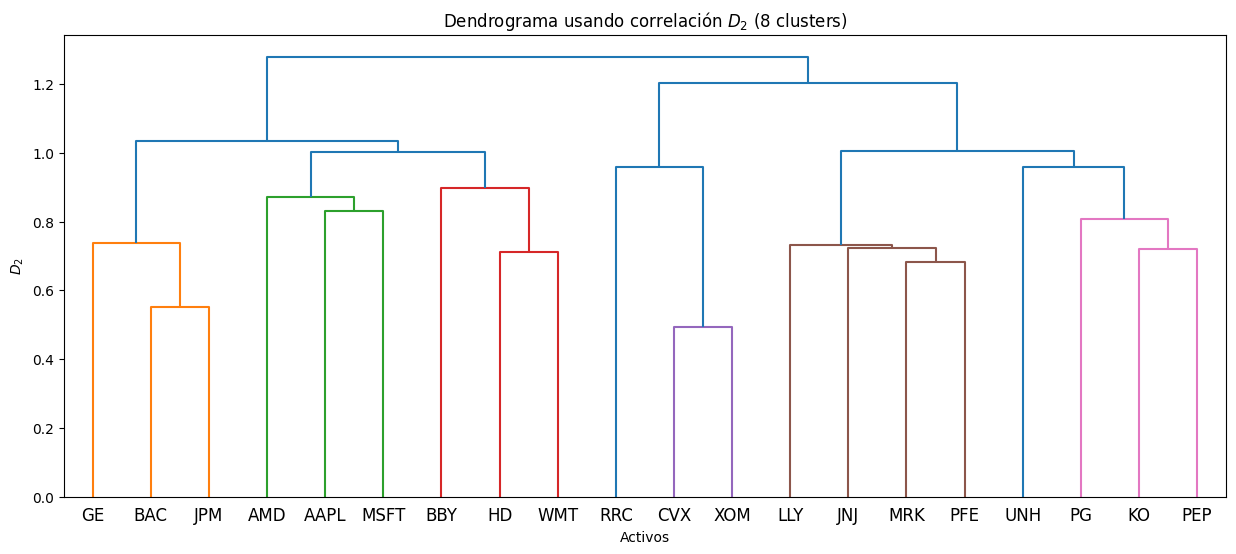

In [ ]:
# Dendrograma usando Mantegna

# Construir la matriz de enlace
E_matrix = SP_train.corr('pearson') # np.corrcoef(SP_train.values.T)
D_matrix = normalizar_matriz(np.sqrt(0.5*(1- E_matrix))) # Se ha personalizado como Lopez de Prado (y posteriormente se normalizó)
D_matrix = np.around(D_matrix, decimals=7)
D_condensed = ssd.squareform(D_matrix)

# Calcular la matriz de enlace usando clustering jerárquico
linkage_matrix = linkage(D_condensed, method = 'ward', optimal_ordering=False)

cutoff = 0.73*max(linkage_matrix[:,2])
# Z = sch.dendrogram(Y, orientation='right',

# Graficar el dendrograma
plt.figure(figsize=(15, 6))
dendrogram(linkage_matrix, labels= D_matrix.columns, color_threshold=cutoff)#distance_df.columns)
plt.xlabel('Activos')
plt.ylabel('$D_2$')
plt.title('Dendrograma usando correlación $D_2$ (8 clusters)')
plt.show()

In [ ]:
D_matrix.to_csv('corr2_train_20activos_test20.csv')

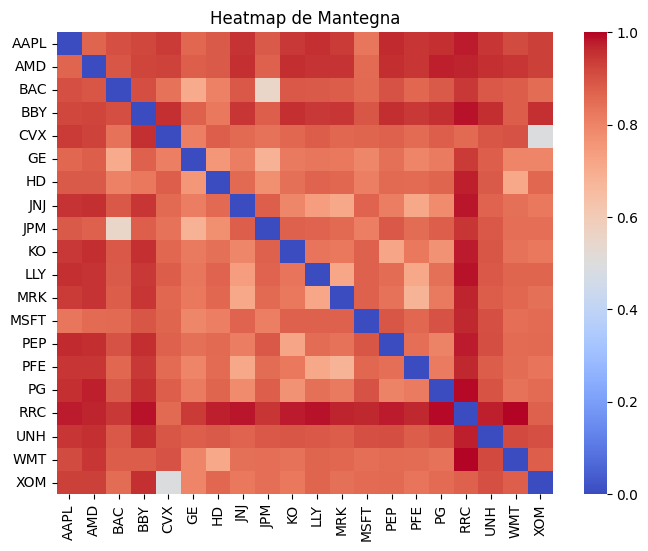

In [ ]:
# Crear un heatmap con la matriz de correlación Mantegna
plt.figure(figsize=(8, 6))
sns.heatmap(D_matrix, cmap='coolwarm', annot=False)
plt.title("Heatmap de Mantegna")
plt.show()

In [ ]:
# Calcular el valor de GAP usando la libreria gap_statistic

# Definir la función de clustering con argumentos adicionales
def kmeans_clusterer(data, *args, **kwargs):
    kmeans = KMeans(**kwargs)
    kmeans.fit(data)
    return kmeans

# Definir un wrapper para AgglomerativeClustering
class AgglomerativeClusteringWrapper:
    def __init__(self, n_clusters, linkage='ward'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)

    def fit(self, X):
        self.model.fit(X)
        self.labels_ = self.model.labels_
        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

# Crear una función de clustering jerárquico usando el wrapper
def hierarchical_clustering(n_clusters):
    return AgglomerativeClusteringWrapper(n_clusters=n_clusters, linkage='ward')


# Configurar y ejecutar OptimalK
optimal_K = OptimalK(
    n_jobs=-1,  # Usar todos los núcleos disponibles
    parallel_backend='multiprocessing',#'joblib',  # Backend para la paralelización
    #clusterer=kmeans_clusterer,# Algoritmo de clustering
    clusterer_kwargs={'n_init': 10, 'max_iter': 10},  # Parámetros adicionales para KMeans
    random_state=12  # Reproducibilidad
)

# Crear una instancia de OptimalK con AgglomerativeClustering
optimalK = OptimalK(parallel_backend='joblib',
                    clusterer=hierarchical_clustering,#AgglomerativeClustering,
                    #clusterer_kwargs={'linkage': 'ward'},
                    random_state=12
)

In [ ]:
# Obtener el número óptimo de clusters
n_clusters = optimal_K(D_matrix.values, cluster_array=np.arange(1, 12))

print("Número óptimo de clusters:", n_clusters)

Número óptimo de clusters: 11


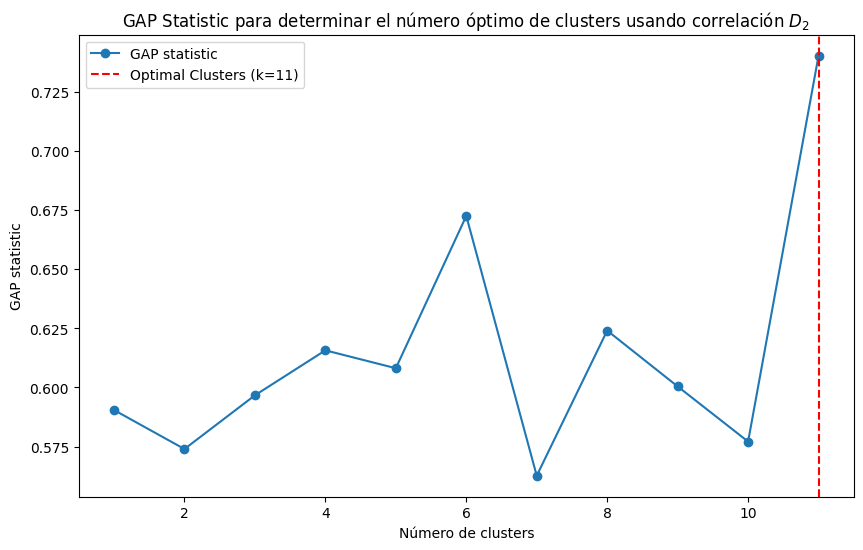

In [ ]:
# Obtener valores GAP
gaps = optimal_K.gap_df['gap_value']
k_values = optimal_K.gap_df['n_clusters']

# Graficar el GAP statistic
plt.figure(figsize=(10, 6))
plt.plot(k_values, gaps, '-o', label='GAP statistic')
plt.axvline(x=n_clusters, linestyle='--', color='red', label=f'Optimal Clusters (k={n_clusters})')
plt.xlabel('Número de clusters')
plt.ylabel('GAP statistic')
plt.title('GAP Statistic para determinar el número óptimo de clusters usando correlación $D_2$')
plt.legend()
plt.show()

In [ ]:
# Obtener las etiquetas de cluster para 4 clusters (revisar posteriormente si coincide con lo que GAP sugiere)
num_clusters = n_clusters
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

In [ ]:
# Crear un DataFrame con las etiquetas de cluster
cluster_df = pd.DataFrame({
    'Stock': SP.columns, #distance_df.columns,
    'Cluster': cluster_labels
})

print("Clusters asignados:")
cluster_df.sort_index()
print(cluster_df)

Clusters asignados:
   Stock  Cluster
0   AAPL        2
1    AMD        4
2    BAC        1
3    BBY        6
4    CVX        7
5     GE        1
6     HD        5
7    JNJ        9
8    JPM        1
9     KO       10
10   LLY        9
11   MRK        9
12  MSFT        3
13   PEP       10
14   PFE        9
15    PG       10
16   RRC        8
17   UNH       11
18   WMT        5
19   XOM        7


In [ ]:
# Obtener índices de agrupación y asignaciones de peso
index_assets, weight_assets = hcaa_alocation(SP_train.values, n_clusters=n_clusters, inverse_data = True)
print(index_assets, weight_assets)

[8, 2, 5, 14, 11, 7, 10, 17, 9, 13, 15, 19, 4, 16, 18, 6, 3, 1, 12, 0] [0.083333, 0.083333, 0.083333, 0.03125, 0.03125, 0.03125, 0.03125, 0.0625, 0.020833, 0.020833, 0.020833, 0.0625, 0.0625, 0.125, 0.03125, 0.03125, 0.0625, 0.0625, 0.03125, 0.03125]


In [ ]:
# Calculamos los retornos usando la asignación obtenida
selected_assets_returns = SP_test.iloc[:, index_assets]
portfolio_returns = selected_assets_returns @ weight_assets

# Calcular la volatilidad de los activos
asset_volatilities = np.std(portfolio_returns, axis=0, ddof=1)  # Usamos ddof=1 para calcular la desviación estándar muestral

# Fijamos un valor de risk free rate de cero como en el articulo de Raffinot
risk_free_rate = 0.0

In [ ]:
# Funciones para calcular el Sharpe Ratio y el ASR

def calculate_sharpe_ratio(returns, risk_free_rate):
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev
    return sharpe_ratio

def calculate_asr(returns, risk_free_rate):
    sharpe_ratio = calculate_sharpe_ratio(returns, risk_free_rate)
    skewness = skew(returns.values.flatten())
    excess_kurtosis = kurtosis(returns.values.flatten()) - 3  # Subtracting 3 to get excess kurtosis
    asr = sharpe_ratio + (sharpe_ratio **2)* (skewness*2 / 6) - (excess_kurtosis / 24)*sharpe_ratio**3
    return asr

In [ ]:
asr = calculate_asr(portfolio_returns, risk_free_rate=risk_free_rate)
print("ASR:", asr)

ASR: 0.05281016504395967


In [ ]:
sharpe_ratio =  calculate_sharpe_ratio(portfolio_returns, risk_free_rate = risk_free_rate)
print("SR:", sharpe_ratio)

SR: 0.05260073000580229


In [ ]:
np.mean(portfolio_returns)

0.07559717076146075

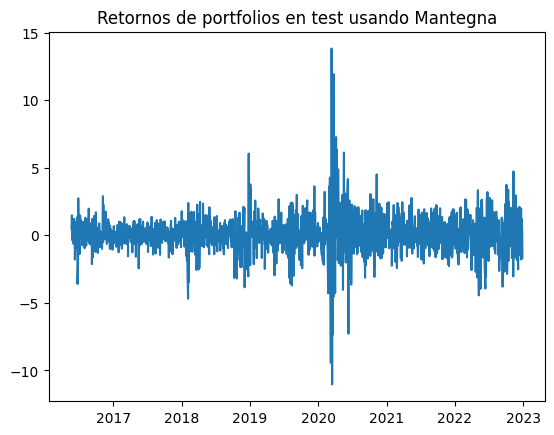

In [ ]:
plt.plot(portfolio_returns)
plt.title('Retornos de portfolios en test usando Mantegna')
plt.show()

In [ ]:
# Definimos una función que calcule ASR para distintos no. de grupos y tasas de riesgos

def calculate_asr_clust(X_train, X_test, num_clusters, risk_free_rate):
    index_assets, weight_assets = hcaa_alocation(X_train.values, n_clusters= num_clusters, inverse_data = True)
    # rendimientos = prices_to_returns(X)
    selected_assets_returns = X_test.iloc[:, index_assets]
    portfolio_returns = selected_assets_returns @ weight_assets
    asset_volatilities = np.std(portfolio_returns, axis=0, ddof=1)
    asr = calculate_asr(portfolio_returns, risk_free_rate = risk_free_rate)
    return asr

In [ ]:
# Variar el asr por el número de clusters
asr_clust = []
for i in range(15):
  asr_clust.append(calculate_asr_clust(SP_train, SP_test, i, 0.000))

In [ ]:
asr_clust

[0.06401430908524021,
 0.06401430908524021,
 0.06401430908524021,
 0.05853217810088287,
 0.05271616630381411,
 0.05271616630381411,
 0.05271616630381412,
 0.05345974416195809,
 0.05168219975721661,
 0.0516656964473192,
 0.05281016504395967,
 0.05281016504395967,
 0.052907558119661344,
 0.04976239093614366,
 0.051029128917408115]

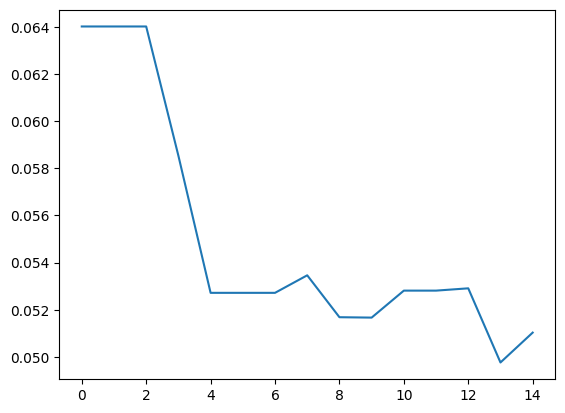

In [ ]:
plt.plot(asr_clust)

# Correlación directa

In [ ]:
# Cambio de Mantegna a correlación

# function to get the weight of the cluster.
def hcaa_alocation(mat_X: np.matrix, n_clusters:int = 0, custom_corr =np.corrcoef ,inverse_data = True, cutoff_point: float = None, return_groups: bool = False)->tuple:
    # Convertir matriz de datos en matriz de distancias
    if not inverse_data:
        E_matrix = custom_corr(mat_X)
    else:
        E_matrix = custom_corr(mat_X.T)
    D_matrix = normalizar_matriz(1- E_matrix)
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, 'ward', optimal_ordering = True)
    if cutoff_point:
        n_clusters = get_groups(Z, cutoff_point)
    n_filas = mat_X.shape[1]
    levels = get_levels(n_clusters, n_filas, Z)
    index_asset = []
    capital_all = []
    index_assets_groups = []
    for index, node_id in enumerate(levels[0]):
        if node_id <= n_filas-1:
            index_asset.append(node_id)
            capital_all.append(levels[1][index])
        else:
            assets = get_leaves(node_id, Z, n_filas)
            cluster_weight = levels[1][index]
            asset_weight = round(cluster_weight/len(assets), 6)
            index_assets_groups.append(assets)
            index_asset += assets
            capital_all += [asset_weight] *len(assets)
    if return_groups:
        return (index_asset, capital_all, index_assets_groups)
    return (index_asset, capital_all)

In [ ]:
D_matrix

,AAPL,AMD,BAC,BBY,CVX,GE,HD,JNJ,JPM,KO,LLY,MRK,MSFT,PEP,PFE,PG,RRC,UNH,WMT,XOM
AAPL,0.000000,0.866406,0.904737,0.920080,0.938174,0.863187,0.883890,0.951446,0.884479,0.944597,0.954449,0.940766,0.830053,0.964725,0.945616,0.955292,0.977919,0.946288,0.913976,0.931918
AMD,0.866406,0.000000,0.892540,0.922301,0.926246,0.875189,0.883927,0.955677,0.871281,0.958750,0.952205,0.949789,0.854204,0.960225,0.946392,0.975845,0.970662,0.956579,0.946433,0.930443
BAC,0.904737,0.892540,0.000000,0.906268,0.837672,0.704738,0.808163,0.887069,0.551133,0.888248,0.886462,0.882386,0.857052,0.899201,0.863139,0.884423,0.945074,0.887673,0.881769,0.851283
BBY,0.920080,0.922301,0.906268,0.000000,0.954359,0.871670,0.827645,0.948969,0.877713,0.956319,0.945180,0.949069,0.890642,0.957575,0.943389,0.955045,0.984734,0.960622,0.880897,0.955566
CVX,0.938174,0.926246,0.837672,0.954359,0.000000,0.809349,0.876016,0.858360,0.839115,0.860096,0.882564,0.859492,0.865672,0.874194,0.853176,0.876600,0.856449,0.893629,0.901308,0.492351
GE,0.863187,0.875189,0.704738,0.871670,0.809349,0.000000,0.754664,0.813594,0.685541,0.820823,0.829500,0.825119,0.793231,0.843090,0.799198,0.820121,0.941124,0.878505,0.798468,0.797971
HD,0.883890,0.883927,0.808163,0.827645,0.876016,0.754664,0.000000,0.857853,0.773877,0.842404,0.867787,0.861799,0.809391,0.856600,0.854632,0.864873,0.973216,0.884278,0.711583,0.862823
JNJ,0.951446,0.955677,0.887069,0.948969,0.858360,0.813594,0.857853,0.000000,0.875457,0.793501,0.740184,0.713386,0.867721,0.815237,0.712448,0.782514,0.982733,0.870015,0.843175,0.826418
JPM,0.884479,0.871281,0.551133,0.877713,0.839115,0.685541,0.773877,0.875457,0.000000,0.873357,0.868441,0.856085,0.809851,0.889778,0.850258,0.875698,0.946378,0.887009,0.846297,0.843776
KO,0.944597,0.958750,0.888248,0.956319,0.860096,0.820823,0.842404,0.793501,0.873357,0.000000,0.833719,0.827898,0.874432,0.719956,0.827099,0.765920,0.979841,0.893213,0.836488,0.826386


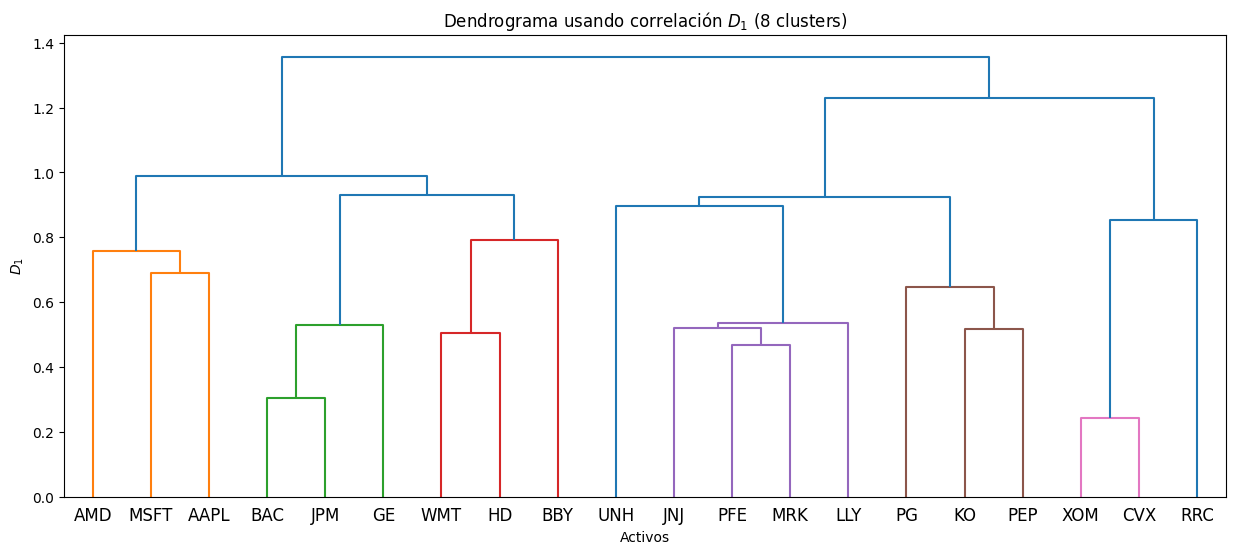

In [ ]:
# Dendrograma usando correción directa

# Construir la matriz de enlace
E_matrix = SP_train.corr('pearson') #np.corrcoef(psi20.values.T)
D_matrix = normalizar_matriz(1- E_matrix)
D_matrix = np.around(D_matrix, decimals=7)
D_condensed = ssd.squareform(D_matrix)

# Calcular la matriz de enlace usando clustering jerárquico
linkage_matrix = linkage(D_condensed, method = 'ward', optimal_ordering=True)


cutoff = 0.6*max(linkage_matrix[:,2])

# Graficar el dendrograma
plt.figure(figsize=(15, 6))
dendrogram(linkage_matrix, labels= D_matrix.columns, color_threshold= cutoff)
plt.xlabel('Activos')
plt.ylabel('$D_1$')
plt.title('Dendrograma usando correlación $D_1$ (8 clusters)')
plt.show()

In [ ]:
D_matrix

,AAPL,AMD,BAC,BBY,CVX,GE,HD,JNJ,JPM,KO,LLY,MRK,MSFT,PEP,PFE,PG,RRC,UNH,WMT,XOM
AAPL,0.000000,0.750659,0.818549,0.846547,0.880171,0.745092,0.781262,0.905250,0.782303,0.892263,0.910973,0.885040,0.688987,0.930694,0.894190,0.912582,0.956326,0.895462,0.835352,0.868471
AMD,0.750659,0.000000,0.796628,0.850639,0.857932,0.765955,0.781327,0.913319,0.759131,0.919200,0.906694,0.902100,0.729664,0.922031,0.895658,0.952274,0.942184,0.915044,0.895736,0.865723
BAC,0.818549,0.796628,0.000000,0.821322,0.701695,0.496655,0.653127,0.786891,0.303748,0.788985,0.785815,0.778604,0.734539,0.808563,0.745009,0.782204,0.893165,0.787963,0.777517,0.724682
BBY,0.846547,0.850639,0.821322,0.000000,0.910801,0.759808,0.684996,0.900542,0.770380,0.914546,0.893365,0.900732,0.793243,0.916949,0.889983,0.912112,0.969701,0.922795,0.775979,0.913107
CVX,0.880171,0.857932,0.701695,0.910801,0.000000,0.655046,0.767404,0.736781,0.704113,0.739766,0.778919,0.738726,0.749387,0.764215,0.727909,0.768428,0.733506,0.798573,0.812355,0.242409
GE,0.745092,0.765955,0.496655,0.759808,0.655046,0.000000,0.569517,0.661936,0.469966,0.673751,0.688070,0.680822,0.629216,0.710801,0.638718,0.672598,0.885715,0.771770,0.637551,0.636757
HD,0.781262,0.781327,0.653127,0.684996,0.767404,0.569517,0.000000,0.735912,0.598886,0.709644,0.753054,0.742698,0.655114,0.733763,0.730395,0.748005,0.947149,0.781947,0.506350,0.744464
JNJ,0.905250,0.913319,0.786891,0.900542,0.736781,0.661936,0.735912,0.000000,0.766426,0.629643,0.547872,0.508919,0.752940,0.664611,0.507582,0.612329,0.965765,0.756926,0.710945,0.682966
JPM,0.782303,0.759131,0.303748,0.770380,0.704113,0.469966,0.598886,0.766426,0.000000,0.762752,0.754190,0.732881,0.655859,0.791705,0.722938,0.766847,0.895631,0.786785,0.716219,0.711958
KO,0.892263,0.919200,0.788985,0.914546,0.739766,0.673751,0.709644,0.629643,0.762752,0.000000,0.695088,0.685415,0.764632,0.518337,0.684093,0.586634,0.960089,0.797829,0.699712,0.682914


In [ ]:
D_matrix.to_csv('corr1_train_20activos_test20.csv')

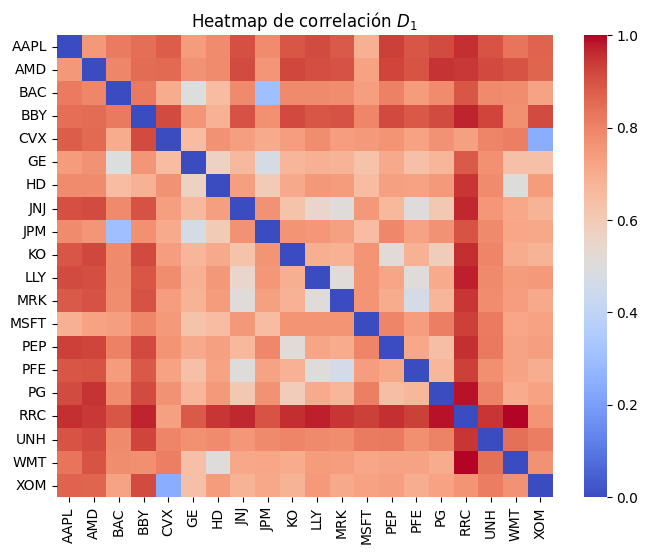

In [ ]:
# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(D_matrix, cmap='coolwarm', annot=False)
plt.title("Heatmap de correlación $D_1$")
plt.show()

In [ ]:
# Calcular el valor de GAP usando la libreria gapstatistics

# gs = GapStatistics(distance_metric='euclidean', pca_sampling=False)

# optimum = gs.fit_predict(K=10, X=np.array(SP_train), n_iterations=30)

# print(f'Optimum: {optimum}')

# Calcular el valor de GAP usando la libreria gap_statistic

# Definir la función de clustering con argumentos adicionales
def kmeans_clusterer(data, *args, **kwargs):
    kmeans = KMeans(**kwargs)
    kmeans.fit(data)
    return kmeans

# Configurar y ejecutar OptimalK
optimal_K = OptimalK(
    n_jobs=-1,  # Usar todos los núcleos disponibles
    parallel_backend='multiprocessing',#'joblib',  # Backend para la paralelización
    #clusterer=kmeans_clusterer,# Algoritmo de clustering
    clusterer_kwargs={'n_init': 1000, 'max_iter': 100000},  # Parámetros adicionales para KMeans
    random_state=12  # Reproducibilidad
)

# Obtener el número óptimo de clusters
n_clusters = optimal_K(D_matrix.values, cluster_array=np.arange(1, 12))

print("Número óptimo de clusters:", n_clusters)

Número óptimo de clusters: 8


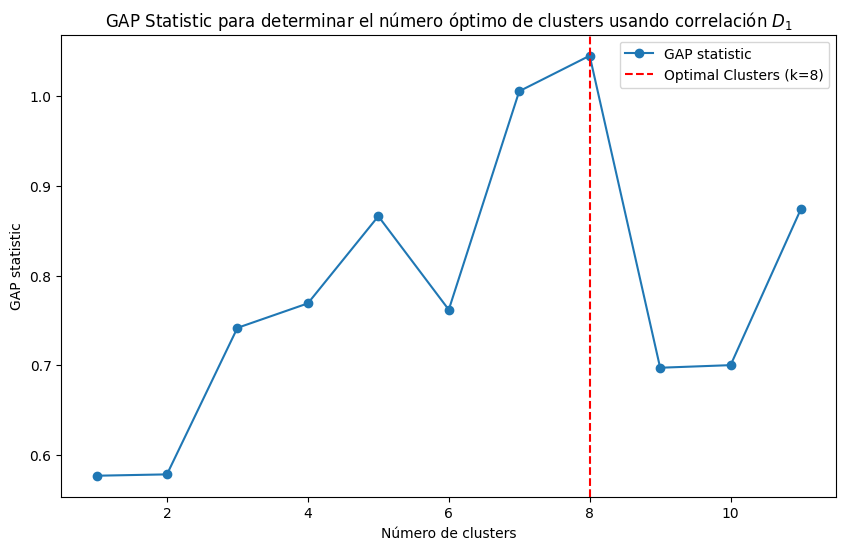

In [ ]:
# Obtener valores GAP
gaps = optimal_K.gap_df['gap_value']
k_values = optimal_K.gap_df['n_clusters']

# Graficar el GAP statistic
plt.figure(figsize=(10, 6))
plt.plot(k_values, gaps, '-o', label='GAP statistic')
plt.axvline(x=n_clusters, linestyle='--', color='red', label=f'Optimal Clusters (k={n_clusters})')
plt.xlabel('Número de clusters')
plt.ylabel('GAP statistic')
plt.title('GAP Statistic para determinar el número óptimo de clusters usando correlación $D_1$')
plt.legend()
plt.show()

In [ ]:
index_assets, weight_assets = hcaa_alocation(SP_train.values, n_clusters=n_clusters, inverse_data = True)
print(index_assets, weight_assets)
selected_assets_returns = SP_test.iloc[:, index_assets]
portfolio_returns = selected_assets_returns @ weight_assets
asset_volatilities = np.std(portfolio_returns, axis=0, ddof=1)  # Usamos ddof=1 para calcular la desviación estándar muestral

# Fijamos un valor de risk free rate de cero como en el articulo de Raffinot
risk_free_rate = 0.0

asr = calculate_asr(portfolio_returns, risk_free_rate)
print("ASR:", asr)

[12, 0, 1, 2, 8, 5, 18, 6, 3, 9, 13, 15, 17, 14, 11, 7, 10, 19, 4, 16] [0.083333, 0.083333, 0.083333, 0.041667, 0.041667, 0.041667, 0.041667, 0.041667, 0.041667, 0.041667, 0.041667, 0.041667, 0.0625, 0.015625, 0.015625, 0.015625, 0.015625, 0.0625, 0.0625, 0.125]
ASR: 0.06124310912351106


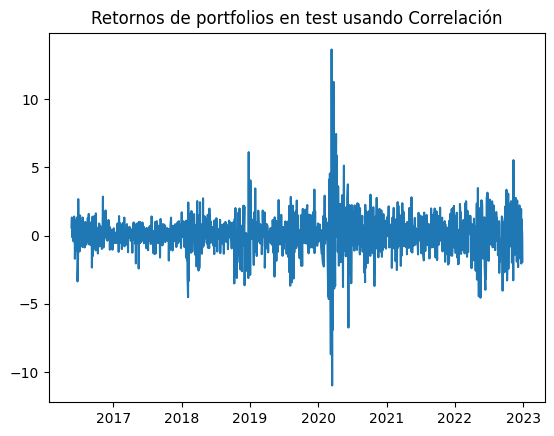

In [ ]:
plt.plot(portfolio_returns)
plt.title('Retornos de portfolios en test usando Correlación')
plt.show()

In [ ]:
# Definimos una función que calcule ASR para distintos no. de grupos y tasas de riesgos

def calculate_asr_clust(X_train, X_test, num_clusters, risk_free_rate):
    index_assets, weight_assets = hcaa_alocation(X_train.values, n_clusters= num_clusters, inverse_data = True)
    # rendimientos = prices_to_returns(X)
    selected_assets_returns = X_test.iloc[:, index_assets]
    portfolio_returns = selected_assets_returns @ weight_assets
    asset_volatilities = np.std(portfolio_returns, axis=0, ddof=1)
    asr = calculate_asr(portfolio_returns, risk_free_rate = risk_free_rate)
    return asr

In [ ]:
# Variar el asr por el número de clusters
asr_clust = []
for i in range(15):
  asr_clust.append(calculate_asr_clust(SP_train, SP_test, i, 0.000))

In [ ]:
calculate_asr_clust(SP_train, SP_test, n_clusters,  0.0001)

0.06117154903956547

In [ ]:
calculate_asr_clust(SP_train, SP_test, n_clusters,  0.000)

0.06124310912351106

In [ ]:
asr_clust

[0.0640143090852402,
 0.0640143090852402,
 0.0640143090852402,
 0.05853217810088285,
 0.06346419725251956,
 0.06346419725251956,
 0.06297639366298494,
 0.06325115198509933,
 0.06124310912351106,
 0.06115259109163169,
 0.0626495079689191,
 0.0626495079689191,
 0.06284326628041713,
 0.06345698435909068,
 0.061953266962020144]

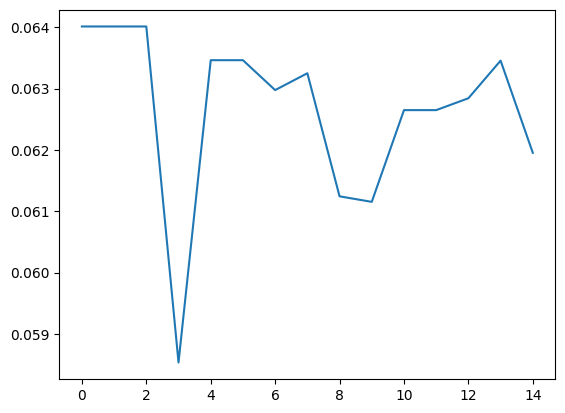

In [ ]:
plt.plot(asr_clust)

# Realizando lo mismo con DTW

In [ ]:
! pip install dtw-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.5/770.5 kB 8.0 MB/s eta 0:00:00


In [ ]:
from dtw import dtw

# Cambio de correlación a DTW

# Función para calcular la distancia DTW entre dos series temporales
def calculate_dtw_distance(series1, series2, symmetric = 1):
    alignment = dtw(series1.T, series2.T, dist_method="euclidean", step_pattern=f"symmetric{symmetric}")
    # 1: Identica con dtw de R
    # 2: Identica con DTWARP de TSclust
    dist = alignment.distance
    return dist


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
# assets = SP_train.columns

# num_assets = len(assets)
# distance_matrix = np.zeros((num_assets, num_assets))

# for i in range(num_assets):
#     for j in range(num_assets):
#           asset1 = SP_train[assets[i]].values
#           asset2 = SP_train[assets[j]].values
#           distance = calculate_dtw_distance(asset1, asset2, 1) # Se usó DTWARP
#           distance_matrix[i, j] = distance

In [ ]:
# Mostramos la matriz observemos que es simétrica
# pd.DataFrame(normalizar_matriz(distance_matrix))

## DTW paralelizada usando Parallel de joblib

In [ ]:
# Definimos una función que realice el cálculo individual de fila por columna

def calculate_distance(i, j, SP_train, assets):
    asset1 = SP_train[assets[i]].values
    asset2 = SP_train[assets[j]].values
    distance = calculate_dtw_distance(asset1, asset2, 1)  # Se usó DTWARP
    return i, j, distance


In [ ]:
# Definimos la función que permite reducir tiempo de ejecución paralelizando y aporvechando simetría

def parallel_dtw_distance_matrix(mat_X):
    assets = mat_X.columns
    num_assets = len(assets)
    distance_matrix = np.zeros((num_assets, num_assets))

    # Crear las combinaciones únicas (i, j) donde i <= j
    indices = [(i, j) for i in range(num_assets) for j in range(i, num_assets)]

    # Ejecutar en paralelo
    results = Parallel(n_jobs=-1)(delayed(calculate_distance)(i, j, mat_X, assets) for i, j in indices)

    # Rellenar la matriz de distancias usando los resultados
    for i, j, distance in results:
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance  # Aprovechar la simetría

    return distance_matrix

In [ ]:
distance_matrix = pd.read_csv('DTW_train_20activos_test20.csv', index_col=0)

In [ ]:
# Ejemplo de uso donde se observa que coindice con el cálculo normal y reduce el tiempo de 6-7 minutos a 2-3 minutos

# distance_matrix = parallel_dtw_distance_matrix(SP_train)

In [ ]:
DTW_train = pd.DataFrame(normalizar_matriz(distance_matrix))

In [ ]:
distance_matrix

,AAPL,AMD,BAC,BBY,CVX,GE,HD,JNJ,JPM,KO,LLY,MRK,MSFT,PEP,PFE,PG,RRC,UNH,WMT,XOM
AAPL,0.000000,0.911028,0.754407,0.801088,0.661214,0.669234,0.656048,0.665152,0.714701,0.657903,0.658894,0.658737,0.654229,0.656777,0.654357,0.656438,0.864165,0.703085,0.645703,0.657271
AMD,0.911028,0.000000,0.929148,0.951515,0.919200,0.903207,0.891142,0.940481,0.896120,0.928081,0.912402,0.911613,0.887450,0.929862,0.905725,0.935708,1.000000,0.912425,0.912682,0.923953
BAC,0.754407,0.929148,0.000000,0.810565,0.549583,0.520344,0.586024,0.560191,0.498035,0.549403,0.582371,0.572466,0.599468,0.560268,0.572395,0.551526,0.853780,0.639405,0.577828,0.543645
BBY,0.801088,0.951515,0.810565,0.000000,0.750589,0.747787,0.715359,0.749858,0.764621,0.746301,0.737749,0.747912,0.728974,0.740538,0.732977,0.748212,0.919795,0.762263,0.729307,0.750012
CVX,0.661214,0.919200,0.549583,0.750589,0.000000,0.410198,0.469639,0.388765,0.537710,0.393308,0.425719,0.418702,0.486883,0.407971,0.425864,0.386008,0.787514,0.542614,0.433494,0.299811
GE,0.669234,0.903207,0.520344,0.747787,0.410198,0.000000,0.467748,0.411897,0.505153,0.404140,0.449026,0.435100,0.482686,0.423227,0.434973,0.406047,0.813654,0.551678,0.440162,0.399885
HD,0.656048,0.891142,0.586024,0.715359,0.469639,0.467748,0.000000,0.458989,0.553377,0.455311,0.485525,0.485248,0.507793,0.461546,0.476583,0.458936,0.817011,0.570980,0.452973,0.463841
JNJ,0.665152,0.940481,0.560191,0.749858,0.388765,0.411897,0.458989,0.000000,0.542443,0.341758,0.388735,0.381420,0.468786,0.355895,0.389671,0.337754,0.830156,0.528844,0.392532,0.367965
JPM,0.714701,0.896120,0.498035,0.764621,0.537710,0.505153,0.553377,0.542443,0.000000,0.533811,0.558809,0.554016,0.564401,0.543521,0.546073,0.539385,0.828822,0.614279,0.552995,0.531896
KO,0.657903,0.928081,0.549403,0.746301,0.393308,0.404140,0.455311,0.341758,0.533811,0.000000,0.405560,0.400226,0.467117,0.344014,0.407805,0.341094,0.819180,0.531656,0.393199,0.371609


In [ ]:
# DTW_train.index = assets
# DTW_train = DTW_train.set_axis(assets, axis="columns")#, inplace=True)

In [ ]:
DTW_train

,AAPL,AMD,BAC,BBY,CVX,GE,HD,JNJ,JPM,KO,LLY,MRK,MSFT,PEP,PFE,PG,RRC,UNH,WMT,XOM
AAPL,0.000000,0.911028,0.754407,0.801088,0.661214,0.669234,0.656048,0.665152,0.714701,0.657903,0.658894,0.658737,0.654229,0.656777,0.654357,0.656438,0.864165,0.703085,0.645703,0.657271
AMD,0.911028,0.000000,0.929148,0.951515,0.919200,0.903207,0.891142,0.940481,0.896120,0.928081,0.912402,0.911613,0.887450,0.929862,0.905725,0.935708,1.000000,0.912425,0.912682,0.923953
BAC,0.754407,0.929148,0.000000,0.810565,0.549583,0.520344,0.586024,0.560191,0.498035,0.549403,0.582371,0.572466,0.599468,0.560268,0.572395,0.551526,0.853780,0.639405,0.577828,0.543645
BBY,0.801088,0.951515,0.810565,0.000000,0.750589,0.747787,0.715359,0.749858,0.764621,0.746301,0.737749,0.747912,0.728974,0.740538,0.732977,0.748212,0.919795,0.762263,0.729307,0.750012
CVX,0.661214,0.919200,0.549583,0.750589,0.000000,0.410198,0.469639,0.388765,0.537710,0.393308,0.425719,0.418702,0.486883,0.407971,0.425864,0.386008,0.787514,0.542614,0.433494,0.299811
GE,0.669234,0.903207,0.520344,0.747787,0.410198,0.000000,0.467748,0.411897,0.505153,0.404140,0.449026,0.435100,0.482686,0.423227,0.434973,0.406047,0.813654,0.551678,0.440162,0.399885
HD,0.656048,0.891142,0.586024,0.715359,0.469639,0.467748,0.000000,0.458989,0.553377,0.455311,0.485525,0.485248,0.507793,0.461546,0.476583,0.458936,0.817011,0.570980,0.452973,0.463841
JNJ,0.665152,0.940481,0.560191,0.749858,0.388765,0.411897,0.458989,0.000000,0.542443,0.341758,0.388735,0.381420,0.468786,0.355895,0.389671,0.337754,0.830156,0.528844,0.392532,0.367965
JPM,0.714701,0.896120,0.498035,0.764621,0.537710,0.505153,0.553377,0.542443,0.000000,0.533811,0.558809,0.554016,0.564401,0.543521,0.546073,0.539385,0.828822,0.614279,0.552995,0.531896
KO,0.657903,0.928081,0.549403,0.746301,0.393308,0.404140,0.455311,0.341758,0.533811,0.000000,0.405560,0.400226,0.467117,0.344014,0.407805,0.341094,0.819180,0.531656,0.393199,0.371609


In [ ]:
# DTW_train.to_csv('DTW_train_20activos_test20.csv')

In [ ]:
# function to get the weight of the cluster.
def hcaa_alocation(mat_X, n_clusters: int = 0, custom_corr = parallel_dtw_distance_matrix, inverse_data = True, cutoff_point: float = None, return_groups: bool = False)->tuple:
    # Convertir matriz de datos en matriz de distancias Aqui se deja al revés de cómo se hace con correlación porque es columna contra columna
    if inverse_data:
        mat_X = mat_X
    else:
        mat_X = mat_X.T

    # Calcular la matriz de distancias DTW
    distance_matrix = DTW_train #custom_corr(normalizar_matriz(mat_X))

    # Calcular los levels, indexes y asignaciones

    E_matrix = normalizar_matriz(np.mat(distance_matrix))
    D_matrix = E_matrix
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, 'ward', optimal_ordering = True)
    if cutoff_point:
        n_clusters = get_groups(Z, cutoff_point)
    n_filas = mat_X.shape[1]
    levels = get_levels(n_clusters, n_filas, Z)
    index_asset = []
    capital_all = []
    index_assets_groups = []
    for index, node_id in enumerate(levels[0]):
        if node_id <= n_filas-1:
            index_asset.append(node_id)
            capital_all.append(levels[1][index])
        else:
            assets = get_leaves(node_id, Z, n_filas)
            cluster_weight = levels[1][index]
            asset_weight = round(cluster_weight/len(assets), 6)
            index_assets_groups.append(assets)
            index_asset += assets
            capital_all += [asset_weight] *len(assets)
    if return_groups:
        return (index_asset, capital_all, index_assets_groups)
    return (index_asset, capital_all)


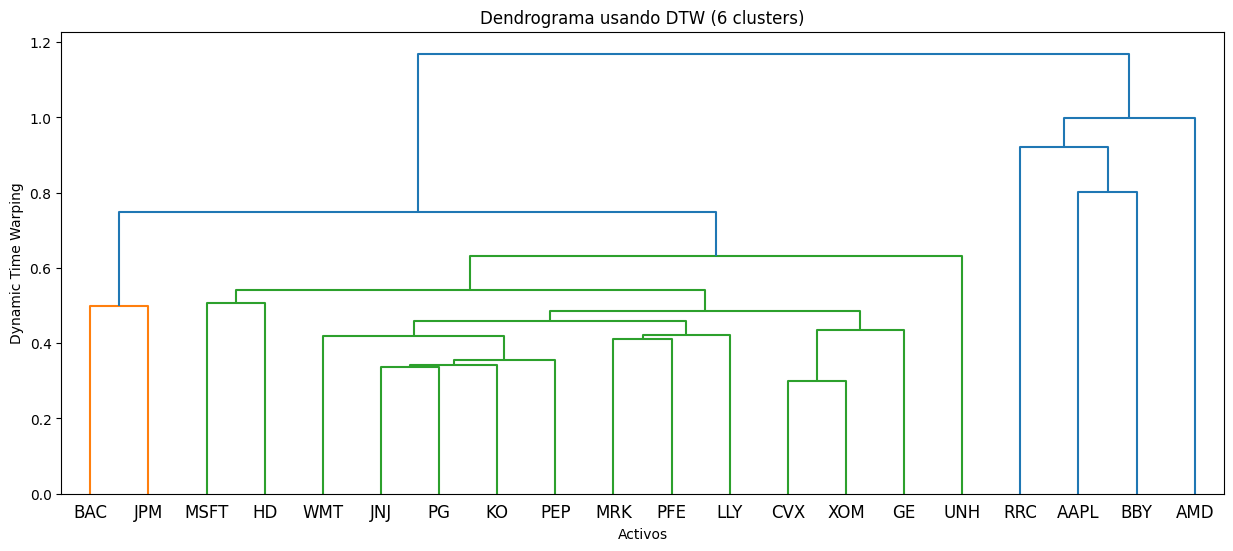

In [ ]:
# Construir la matriz de enlace Z usando mantegna

# D_matrix = normalizar_matriz(distance_matrix)
D_matrix = np.around(DTW_train, decimals=7)
D_condensed = ssd.squareform(D_matrix)
Z = linkage(D_condensed, 'ward', optimal_ordering=True)

# # Obtener información del dendrograma
# levels = get_levels(7, D_matrix.shape[1], Z)
# leaves = [get_leaves(node_id, Z, D_matrix.shape[1]) for node_id in levels[0]]

cutoff = 0.6*max(Z[:,2])

# Dibujar el dendrograma
plt.figure(figsize=(15, 6))
dendrogram(Z,labels=SP_train.columns, color_threshold=cutoff) #leaf_font_size=8,
# dendrogram(linkage_matrix, labels= D_matrix.columns)
plt.title('Dendrograma usando DTW (6 clusters)')
plt.xlabel('Activos')
plt.ylabel('Dynamic Time Warping')
plt.show()

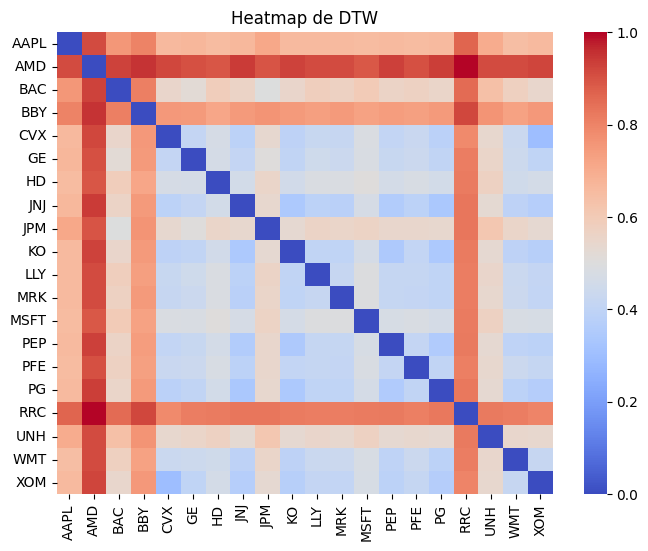

In [ ]:
D_matrix = normalizar_matriz(distance_matrix)
D_matrix = np.around(D_matrix, decimals=7)

plt.figure(figsize=(8, 6))
sns.heatmap(D_matrix, cmap='coolwarm', annot=False)
plt.title("Heatmap de DTW")
plt.show()

In [ ]:
# Calcular el valor de GAP usando la libreria gapstatistics

# gs = GapStatistics(distance_metric='euclidean', pca_sampling=False)

# optimum = gs.fit_predict(K=10, X=np.array(SP_train), n_iterations=30)

# print(f'Optimum: {optimum}')

# Calcular el valor de GAP usando la libreria gap_statistic

# Definir la función de clustering con argumentos adicionales
def kmeans_clusterer(data, *args, **kwargs):
    kmeans = KMeans(**kwargs)
    kmeans.fit(data)
    return kmeans

# Configurar y ejecutar OptimalK
optimal_K = OptimalK(
    n_jobs=-1,  # Usar todos los núcleos disponibles
    parallel_backend='multiprocessing',#'joblib',  # Backend para la paralelización
    #clusterer=kmeans_clusterer,# Algoritmo de clustering
    clusterer_kwargs={'n_init': 10, 'max_iter': 10},  # Parámetros adicionales para KMeans
    random_state=12  # Reproducibilidad
)

# Obtener el número óptimo de clusters
n_clusters = optimal_K(D_matrix, cluster_array=np.arange(1, 12))

print("Número óptimo de clusters:", n_clusters)

Número óptimo de clusters: 11


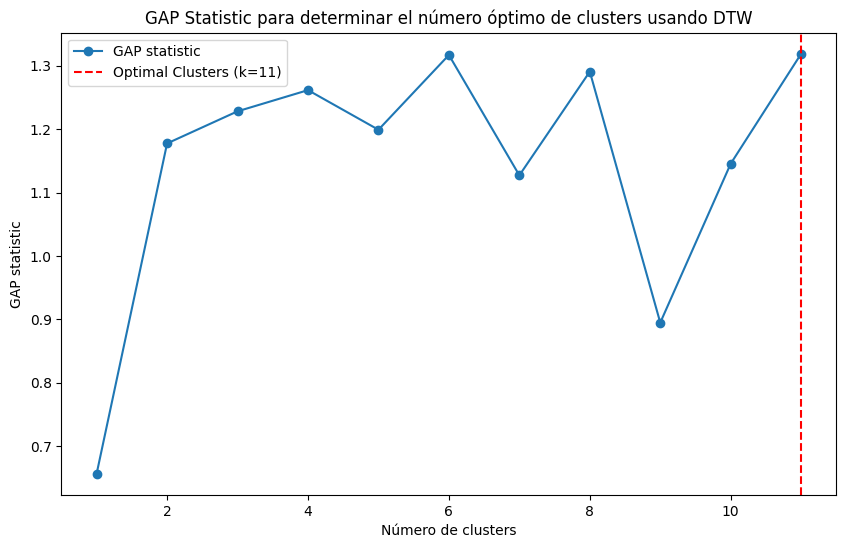

In [ ]:
# Obtener valores GAP
gaps = optimal_K.gap_df['gap_value']
k_values = optimal_K.gap_df['n_clusters']

# Graficar el GAP statistic
plt.figure(figsize=(10, 6))
plt.plot(k_values, gaps, '-o', label='GAP statistic')
plt.axvline(x=n_clusters, linestyle='--', color='red', label=f'Optimal Clusters (k={n_clusters})')
plt.xlabel('Número de clusters')
plt.ylabel('GAP statistic')
plt.title('GAP Statistic para determinar el número óptimo de clusters usando DTW')
plt.legend()
plt.show()

In [ ]:
# Obtener índices de agrupación y asignaciones de peso
index_assets, weight_assets = hcaa_alocation(SP_train, n_clusters=n_clusters, inverse_data = True) #No se coloca .values y true en inverse data pero hcca no lo cambia
print(index_assets, weight_assets)

# Calculamos los retornos usando la asignación obtenida
selected_assets_returns = SP_test.iloc[:, index_assets]
portfolio_returns = selected_assets_returns @ weight_assets

# Calcular la volatilidad de los activos
asset_volatilities = np.std(portfolio_returns, axis=0, ddof=1)  # Usamos ddof=1 para calcular la desviación estándar muestral

# Fijamos un valor de risk free rate de cero como en el articulo de Raffinot
risk_free_rate = 0.0

asr = calculate_asr(portfolio_returns, risk_free_rate)
print("ASR:", asr)

[1, 16, 0, 3, 17, 12, 6, 2, 8, 7, 15, 9, 13, 18, 11, 14, 10, 4, 19, 5] [0.25, 0.125, 0.0625, 0.0625, 0.125, 0.03125, 0.03125, 0.125, 0.125, 0.003906, 0.003906, 0.003906, 0.003906, 0.003906, 0.003906, 0.003906, 0.003906, 0.010417, 0.010417, 0.010417]
ASR: 0.0677592138374097


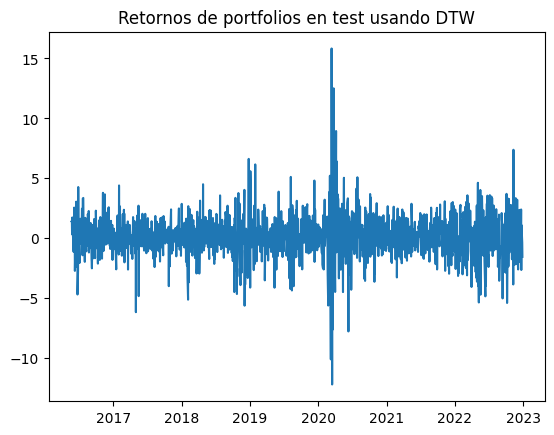

In [ ]:
plt.plot(portfolio_returns)
plt.title('Retornos de portfolios en test usando DTW')
plt.show()

In [ ]:
# Definimos una función que calcule ASR para distintos no. de grupos y tasas de riesgos
# Se envia X_train como Data frame y no como array
# Se envia inverse_data = True pero la función no lo invierte, para que haga el cálculo de DTW correctamente.

def calculate_asr_clust(X_train, X_test, num_clusters, risk_free_rate):
    index_assets, weight_assets = hcaa_alocation(X_train, n_clusters= num_clusters, inverse_data = True)
    selected_assets_returns = X_test.iloc[:, index_assets]
    portfolio_returns = selected_assets_returns @ weight_assets
    asset_volatilities = np.std(portfolio_returns, axis=0, ddof=1)
    asr = calculate_asr(portfolio_returns, risk_free_rate = risk_free_rate)
    return asr #num_clusters, asr, weight_assets, index_assets

In [ ]:
# Variar el asr por el número de clusters
asr_clust = []
for i in range(15):
  asr_clust.append(calculate_asr_clust(SP_train, SP_test, i, 0.000))

In [ ]:
asr_clust

[0.06567604943163265,
 0.06567604943163265,
 0.06567604943163265,
 0.07112754617553044,
 0.06840777510143857,
 0.06840777510143857,
 0.06588436492021878,
 0.06800973070570142,
 0.06836561173178031,
 0.06836561173178031,
 0.06836561173178031,
 0.0677592138374097,
 0.06781078571189517,
 0.06753204824377383,
 0.06761264314894544]

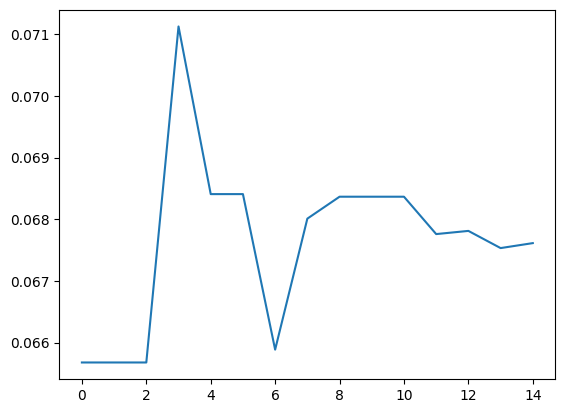

In [ ]:
plt.plot(asr_clust)